C:\Users\andre\AppData\Local\Temp\ipykernel_24304\2357193388.py:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  titanic['age'].fillna(titanic['age'].median(), inplace=True)
C:\Users\andre\AppData\Local\Temp\ipykernel_24304\2357193388.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a 


Logistic Regression Report:
              precision    recall  f1-score   support

           0       0.82      0.84      0.83       165
           1       0.74      0.71      0.72       103

    accuracy                           0.79       268
   macro avg       0.78      0.78      0.78       268
weighted avg       0.79      0.79      0.79       268


SVM Report:
              precision    recall  f1-score   support

           0       0.84      0.87      0.85       165
           1       0.78      0.73      0.75       103

    accuracy                           0.82       268
   macro avg       0.81      0.80      0.80       268
weighted avg       0.82      0.82      0.82       268


Naive Bayes Report:
              precision    recall  f1-score   support

           0       0.81      0.79      0.80       165
           1       0.68      0.70      0.69       103

    accuracy                           0.76       268
   macro avg       0.74      0.75      0.75       268
weighted av

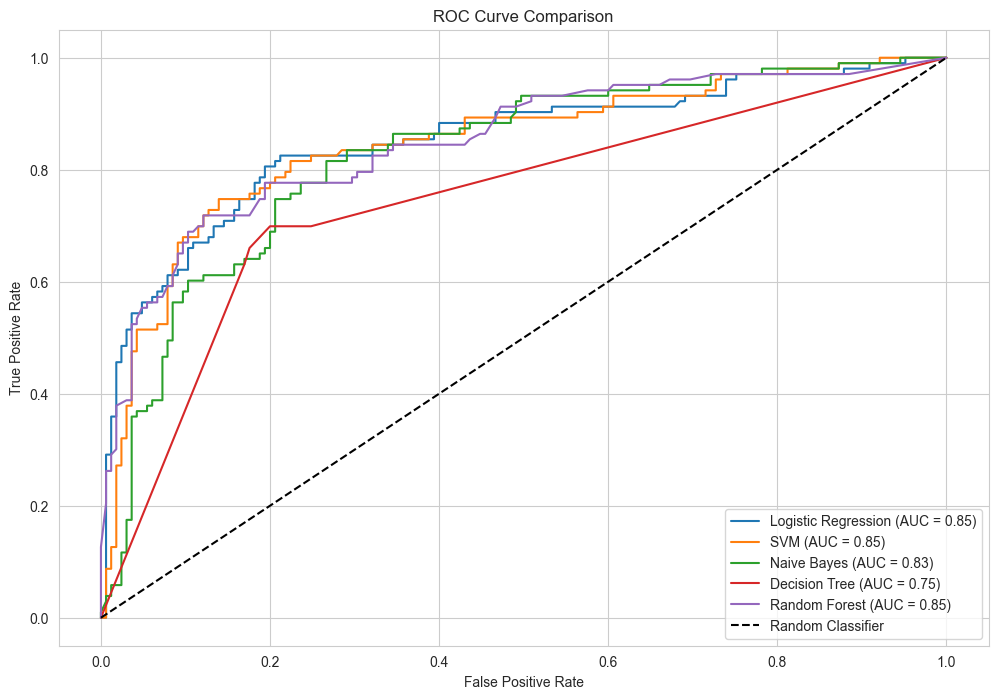

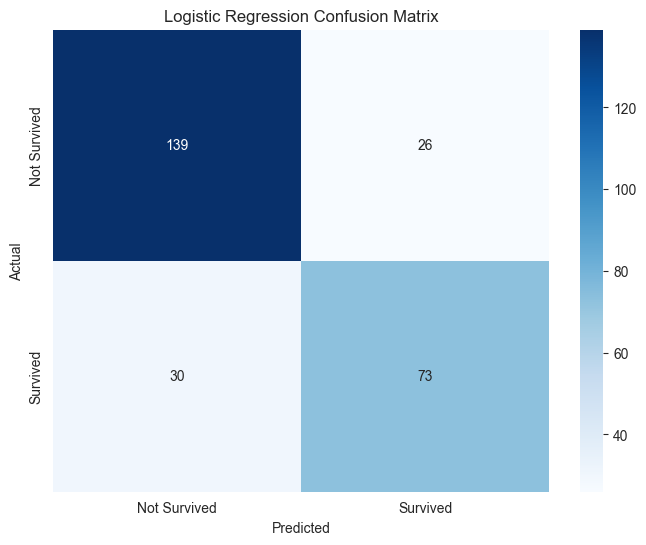

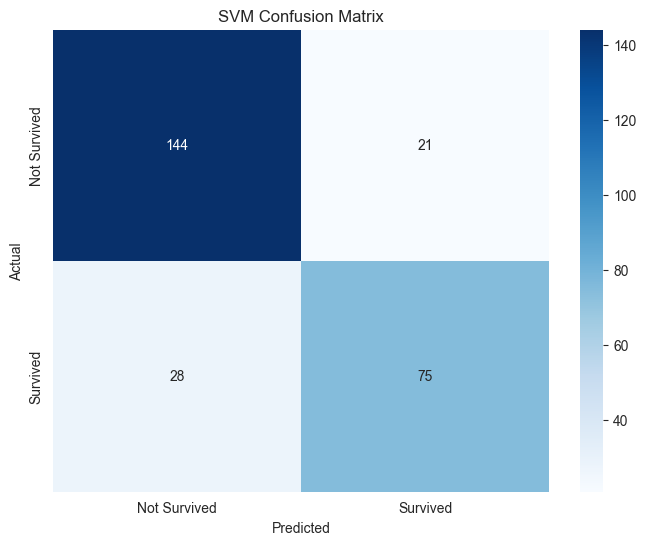

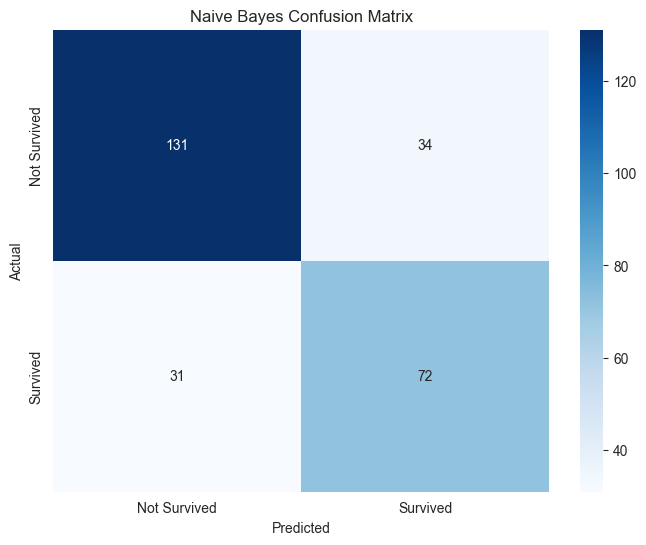

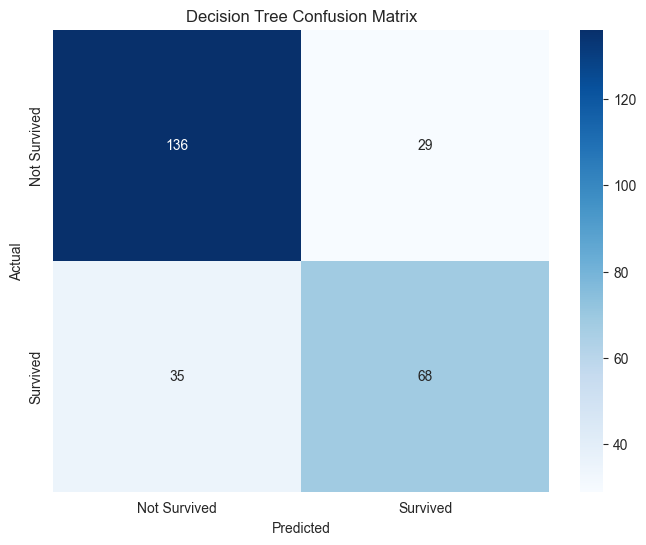

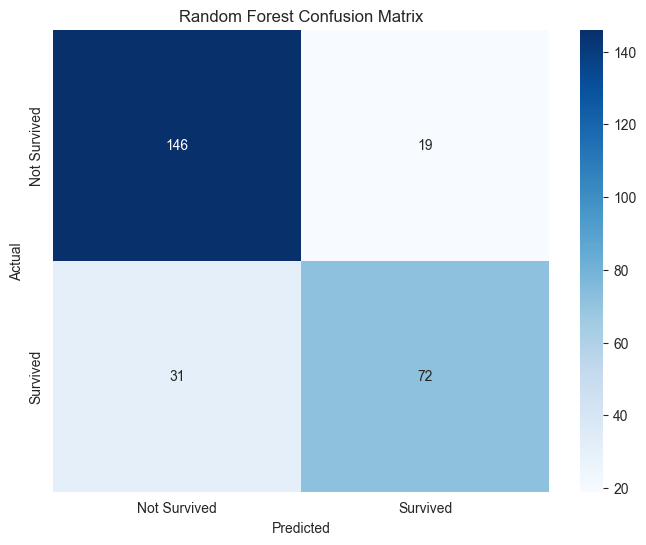


Best performing model: Logistic Regression


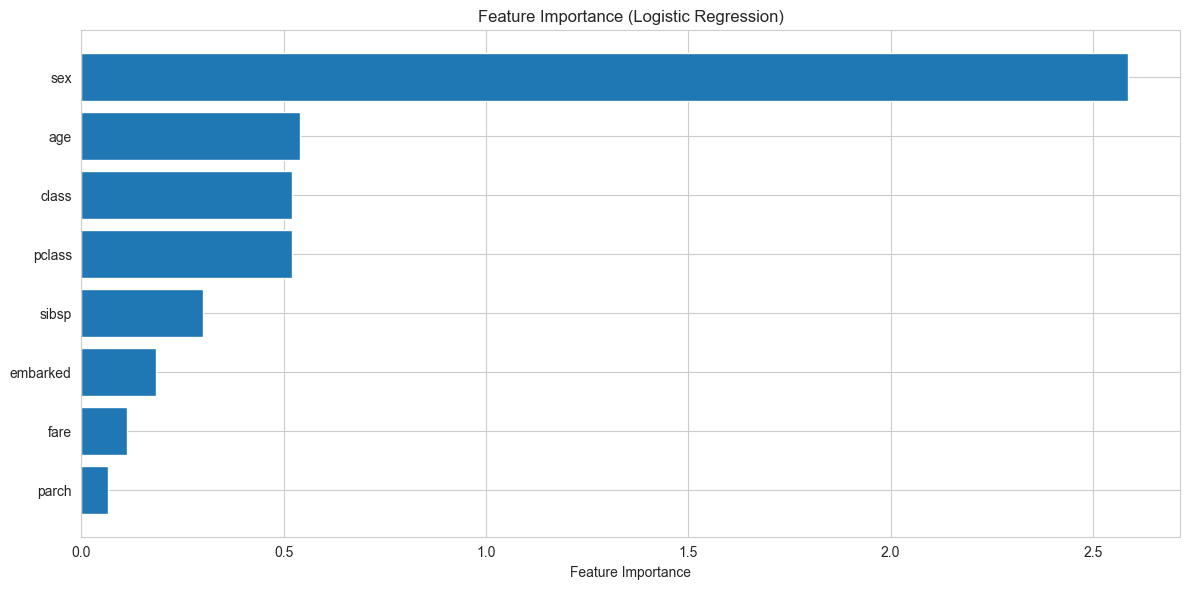

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler

# Load Titanic dataset
titanic = sns.load_dataset('titanic')

# Handle missing values
titanic['age'].fillna(titanic['age'].median(), inplace=True)
titanic['embarked'].fillna(titanic['embarked'].mode()[0], inplace=True)

# Drop irrelevant columns
titanic.drop(columns=['deck', 'embark_town', 'alive'], inplace=True)

# Encode categorical variables
titanic['sex'] = titanic['sex'].map({'male': 0, 'female': 1})
titanic['embarked'] = titanic['embarked'].map({'C': 0, 'Q': 1, 'S': 2})
titanic['class'] = titanic['class'].map({'First': 1, 'Second': 2, 'Third': 3})

# Drop remaining columns with too many NaNs or irrelevant information
titanic.drop(columns=['who', 'adult_male', 'alone'], inplace=True)

# Separate features and target
X = titanic.drop(columns=['survived'])
y = titanic['survived']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Standardize numerical features
scaler = StandardScaler()
X_train[['age', 'fare']] = scaler.fit_transform(X_train[['age', 'fare']])
X_test[['age', 'fare']] = scaler.transform(X_test[['age', 'fare']])

# Initialize all models
models = {
    'Logistic Regression': LogisticRegression(),
    'SVM': SVC(probability=True),
    'Naive Bayes': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42)
}

# Dictionary to store results
results = {}

# Train and evaluate all models
for name, model in models.items():
    # Train model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    # Store results
    results[name] = {
        'y_pred': y_pred,
        'y_prob': y_prob,
        'accuracy': accuracy_score(y_test, y_pred),
        'auc': roc_auc_score(y_test, y_prob)
    }
    
    # Print classification report
    print(f"\n{name} Report:")
    print(classification_report(y_test, y_pred))

# Plot ROC curves
plt.figure(figsize=(12, 8))

for name, result in results.items():
    fpr, tpr, _ = roc_curve(y_test, result['y_prob'])
    plt.plot(fpr, tpr, label=f'{name} (AUC = {result["auc"]:.2f})')

# Add random classifier
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')

# Finalize ROC plot
plt.title("ROC Curve Comparison")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()

# Plot confusion matrices
def plot_confusion_matrix(y_true, y_pred, title):
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=["Not Survived", "Survived"], 
                yticklabels=["Not Survived", "Survived"])
    plt.title(f"{title} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# Plot confusion matrix for each model
for name, result in results.items():
    plot_confusion_matrix(y_test, result['y_pred'], name)

# Feature Importance Analysis

# Get the best performing model based on AUC
best_model_name = max(results.items(), key=lambda x: x[1]['auc'])[0]
print(f"\nBest performing model: {best_model_name}")

# Function to get feature importance
def get_feature_importance(model, feature_names):
    if isinstance(model, RandomForestClassifier):
        return model.feature_importances_
    elif isinstance(model, LogisticRegression):
        return np.abs(model.coef_[0])
    elif isinstance(model, DecisionTreeClassifier):
        return model.feature_importances_
    else:
        return None

# Get feature importance for the best model
best_model = models[best_model_name]
importance = get_feature_importance(best_model, X.columns)

if importance is not None:
    # Create feature importance plot
    plt.figure(figsize=(12, 6))
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': importance
    })
    feature_importance = feature_importance.sort_values('importance', ascending=True)
    
    plt.barh(range(len(importance)), feature_importance['importance'])
    plt.yticks(range(len(importance)), feature_importance['feature'])
    plt.xlabel('Feature Importance')
    plt.title(f'Feature Importance ({best_model_name})')
    plt.tight_layout()
    plt.show()